In [0]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
%matplotlib inline
matplotlib.style.use('ggplot')

In [0]:
stores=pd.read_csv('Insert path of stores file here')

In [0]:
#Insert path to train.csv here
train_1=pd.read_csv('Insert path of train_1 file here')
train_2=pd.read_csv('Insert path of train_2 file here')
train_2.columns = train_1.columns
train=pd.concat([train_1,train_2])
train=train.reset_index(drop=True)

/databricks/python/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
 interactivity=interactivity, compiler=compiler, result=result)

In [0]:
#Insert the path to unseen test.csv
test=pd.read_csv('Insert path of test file here')

In [0]:

def decodePromoInterval(stores):
  months=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
  for month in months:
    stores['{}PromoInterval'.format(month)]=stores['PromoInterval'].str.count(month)
    stores['{}PromoInterval'.format(month)]=stores['{}PromoInterval'.format(month)].fillna(0)
  return stores

In [0]:
def fillNullsForPromo(train_set):
  train_set['Promo2SinceYear']=train_set['Promo2SinceYear'].fillna('2009')
  train_set['Promo2SinceWeek']=train_set['Promo2SinceWeek'].fillna('1')
  train_set['Promo2SinceYear']=train_set['Promo2SinceYear'].astype(int)
  train_set['Promo2SinceWeek']=train_set['Promo2SinceWeek'].astype(int)
  train_set['CompetitionOpenSinceMonth']=train_set['CompetitionOpenSinceMonth'].fillna(train_set['CompetitionOpenSinceMonth'].mean()).astype(int)
  train_set['CompetitionOpenSinceYear']=train_set['CompetitionOpenSinceYear'].fillna(train_set['CompetitionOpenSinceYear'].mean()).astype(int)
  train_set['CompetitionDistance']=train_set['CompetitionDistance'].fillna(train_set['CompetitionDistance'].mean()).astype(int)
  return train_set

In [0]:
def getDaysSincePromo(train_set):
  train_set['formatted_date'] = train_set.Promo2SinceYear * 1000 + train_set.Promo2SinceWeek * 10 + 0
  train_set['Promo2SinceDate'] = pd.to_datetime(train_set['formatted_date'], format='%Y%W%w')
  train_set.loc[train_set['Date'].astype('M8')>= train_set['Promo2SinceDate'], 'DaysSincePromo'] = (train_set['Date'].astype('M8') - train_set['Promo2SinceDate']).dt.days.astype(int)
  train_set.loc[train_set['Date'].astype('M8')< train_set['Promo2SinceDate'], 'DaysSincePromo'] = (train_set['Date'].astype('M8') - train_set['Promo2SinceDate'].min()).dt.days.astype(int)
  return train_set

In [0]:
def oneHotCode(train_set):
  train_set['StateHoliday']=train_set['StateHoliday'].astype(str)
  lb = LabelBinarizer()
  lb_results = lb.fit_transform(train_set['StateHoliday'])
  lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)
  lb_results_df.index=train_set.index
  train_set[['StateHoliday_0','StateHoliday_a','StateHoliday_b','StateHoliday_c']]=lb_results_df
  lb_results = lb.fit_transform(train_set['StoreType'])
  lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)
  lb_results_df.index=train_set.index
  train_set[['StoreType_a','StoreType_b','StoreType_c','StoreType_d']]=lb_results_df
  lb_results = lb.fit_transform(train_set['Assortment'])
  lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)
  lb_results_df.index=train_set.index
  train_set[['Assortment_a','Assortment_b','Assortment_c']]=lb_results_df
  return train_set

In [0]:
def oneHotCodeApply(train_set,test_set):
  lb = LabelBinarizer()
  lb_results = lb.fit_transform(train_set['StateHoliday'])
  lb_results = lb.transform(test_set['StateHoliday'])
  lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)
  lb_results_df.index=test_set.index
  test_set[['StateHoliday_0','StateHoliday_a','StateHoliday_b','StateHoliday_c']]=lb_results_df
  lb_results = lb.fit_transform(train_set['StoreType'])
  lb_results = lb.transform(test_set['StoreType'])
  lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)
  lb_results_df.index=test_set.index
  test_set[['StoreType_a','StoreType_b','StoreType_c','StoreType_d']]=lb_results_df
  lb_results = lb.fit_transform(train_set['Assortment'])
  lb_results = lb.transform(test_set['Assortment'])
  lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)
  lb_results_df.index=test_set.index
  test_set[['Assortment_a','Assortment_b','Assortment_c']]=lb_results_df
  return test_set

In [0]:
def boxPlot(train_set):
  B=plt.boxplot(train_set['Sales'])
  return B
  
def remove_outliers(train_set,B):
  upper_whisker=[item.get_ydata() for item in B['whiskers']][1][1]
  train_set=train_set[train_set['Sales']  <= upper_whisker]
  train_set=train_set.reset_index()
  return train_set

In [0]:
def getBoxPlot(train_set):
  sns.set(rc={'figure.figsize':(16.7,10)})
  sns.boxplot(x=train_set['Sales'])

In [0]:
def getCorrelations(train_set):
  plt.figure(figsize=(22,20))
  cor = train_set[[ 'DayOfWeek', 'Customers', 'Open', 'Promo',
         'StateHoliday'
                       , 'StoreType'
  , 'Assortment',
         'CompetitionDistance',
         'CompetitionOpenSinceYear', 'Promo2','Sales']].corr()
  sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
  plt.show()

In [0]:
def split_train_test(train_set):
  predictors=[ 'Store','DayOfWeek', 'Open', 'Promo',
       'StateHoliday_0', 'StateHoliday_a',
       'StateHoliday_b', 'StateHoliday_c','SchoolHoliday'
                     , 'StoreType_a','StoreType_b','StoreType_c','StoreType_d'
, 'Assortment_a','Assortment_b','Assortment_c',
       'CompetitionDistance',
       'CompetitionOpenSinceYear', 'Promo2', 'JanPromoInterval',
       'FebPromoInterval', 'MarPromoInterval', 'AprPromoInterval',
       'MayPromoInterval', 'JunPromoInterval', 'JulPromoInterval',
       'AugPromoInterval', 'SepPromoInterval', 'OctPromoInterval',
       'NovPromoInterval', 'DecPromoInterval', 'DaysSincePromo']
  target=['Sales']
  x_train=train_set.loc[train_set['Date'] < '2015-07-01', [ 'Store','Date','DayOfWeek', 'Open', 'Promo',
         'StateHoliday_0', 'StateHoliday_a',
         'StateHoliday_b', 'StateHoliday_c','SchoolHoliday'
                       , 'StoreType_a','StoreType_b','StoreType_c','StoreType_d'
  , 'Assortment_a','Assortment_b','Assortment_c',
         'CompetitionDistance',
         'CompetitionOpenSinceYear', 'Promo2', 'JanPromoInterval',
         'FebPromoInterval', 'MarPromoInterval', 'AprPromoInterval',
         'MayPromoInterval', 'JunPromoInterval', 'JulPromoInterval',
         'AugPromoInterval', 'SepPromoInterval', 'OctPromoInterval',
         'NovPromoInterval', 'DecPromoInterval', 'DaysSincePromo']]
  y_train =train_set.loc[train_set['Date'] < '2015-07-01', [ 'Sales']]
  x_cv=train_set.loc[train_set['Date'] >= '2015-07-01', [ 'Store','Date','DayOfWeek', 'Open', 'Promo',
         'StateHoliday_0', 'StateHoliday_a',
         'StateHoliday_b', 'StateHoliday_c','SchoolHoliday'
                       , 'StoreType_a','StoreType_b','StoreType_c','StoreType_d'
  , 'Assortment_a','Assortment_b','Assortment_c',
         'CompetitionDistance',
         'CompetitionOpenSinceYear', 'Promo2', 'JanPromoInterval',
         'FebPromoInterval', 'MarPromoInterval', 'AprPromoInterval',
         'MayPromoInterval', 'JunPromoInterval', 'JulPromoInterval',
         'AugPromoInterval', 'SepPromoInterval', 'OctPromoInterval',
         'NovPromoInterval', 'DecPromoInterval', 'DaysSincePromo']]
  y_cv = train_set.loc[train_set['Date'] >= '2015-07-01', [ 'Sales']]
  return predictors,target,x_train,y_train,x_cv,y_cv


In [0]:
def scores(i):
  predictors=[ 'Store','DayOfWeek', 'Open', 'Promo',
       'StateHoliday_0', 'StateHoliday_a',
       'StateHoliday_b', 'StateHoliday_c','SchoolHoliday'
                     , 'StoreType_a','StoreType_b','StoreType_c','StoreType_d'
, 'Assortment_a','Assortment_b','Assortment_c',
       'CompetitionDistance',
       'CompetitionOpenSinceYear', 'Promo2', 'JanPromoInterval',
       'FebPromoInterval', 'MarPromoInterval', 'AprPromoInterval',
       'MayPromoInterval', 'JunPromoInterval', 'JulPromoInterval',
       'AugPromoInterval', 'SepPromoInterval', 'OctPromoInterval',
       'NovPromoInterval', 'DecPromoInterval', 'DaysSincePromo']
  lin= i()
  lin.fit(x_train[predictors], y_train)
  y_pred=lin.predict(x_cv[predictors])
  lin_r= r2_score(y_cv, y_pred)
  s.append(lin_r)

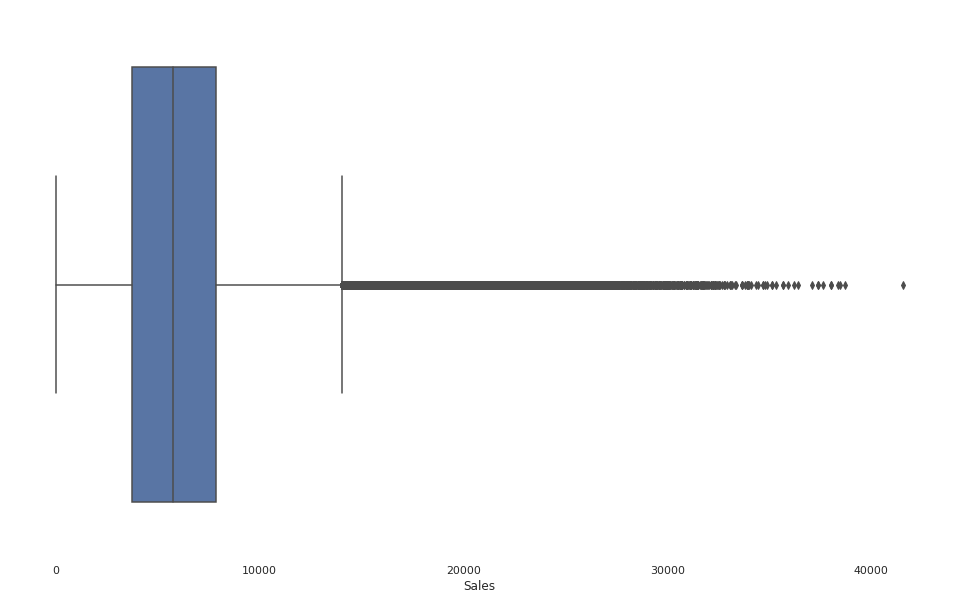

In [0]:
## Data Cleaning
decodePromoInterval(stores)
train_set = train.join(stores.set_index('Store'), on='Store')
fillNullsForPromo(train_set)
getDaysSincePromo(train_set)
oneHotCode(train_set)


## Data Exploration
getBoxPlot(train_set)

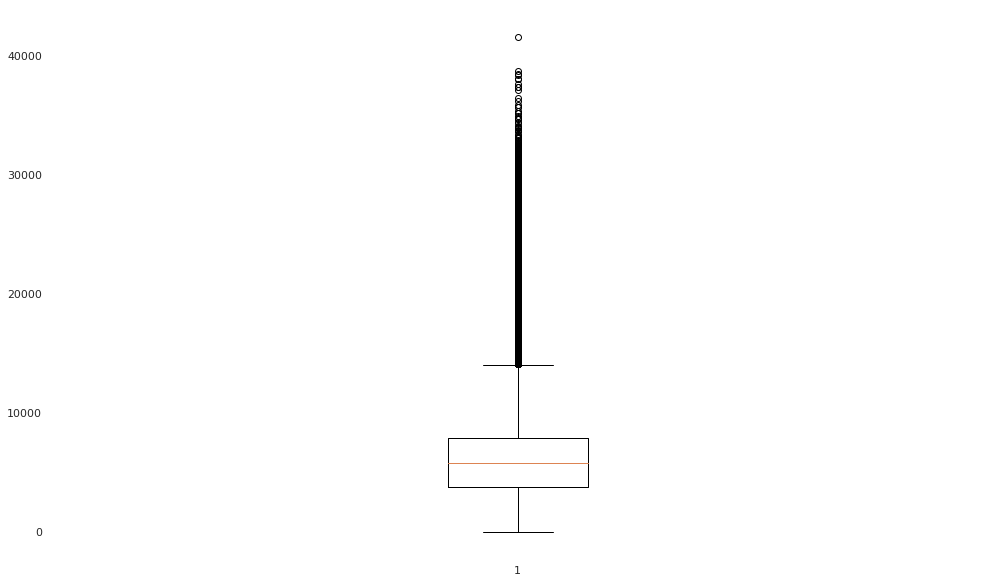

In [0]:
B=plt.boxplot(train_set['Sales'])
train_set=remove_outliers(train_set,B)

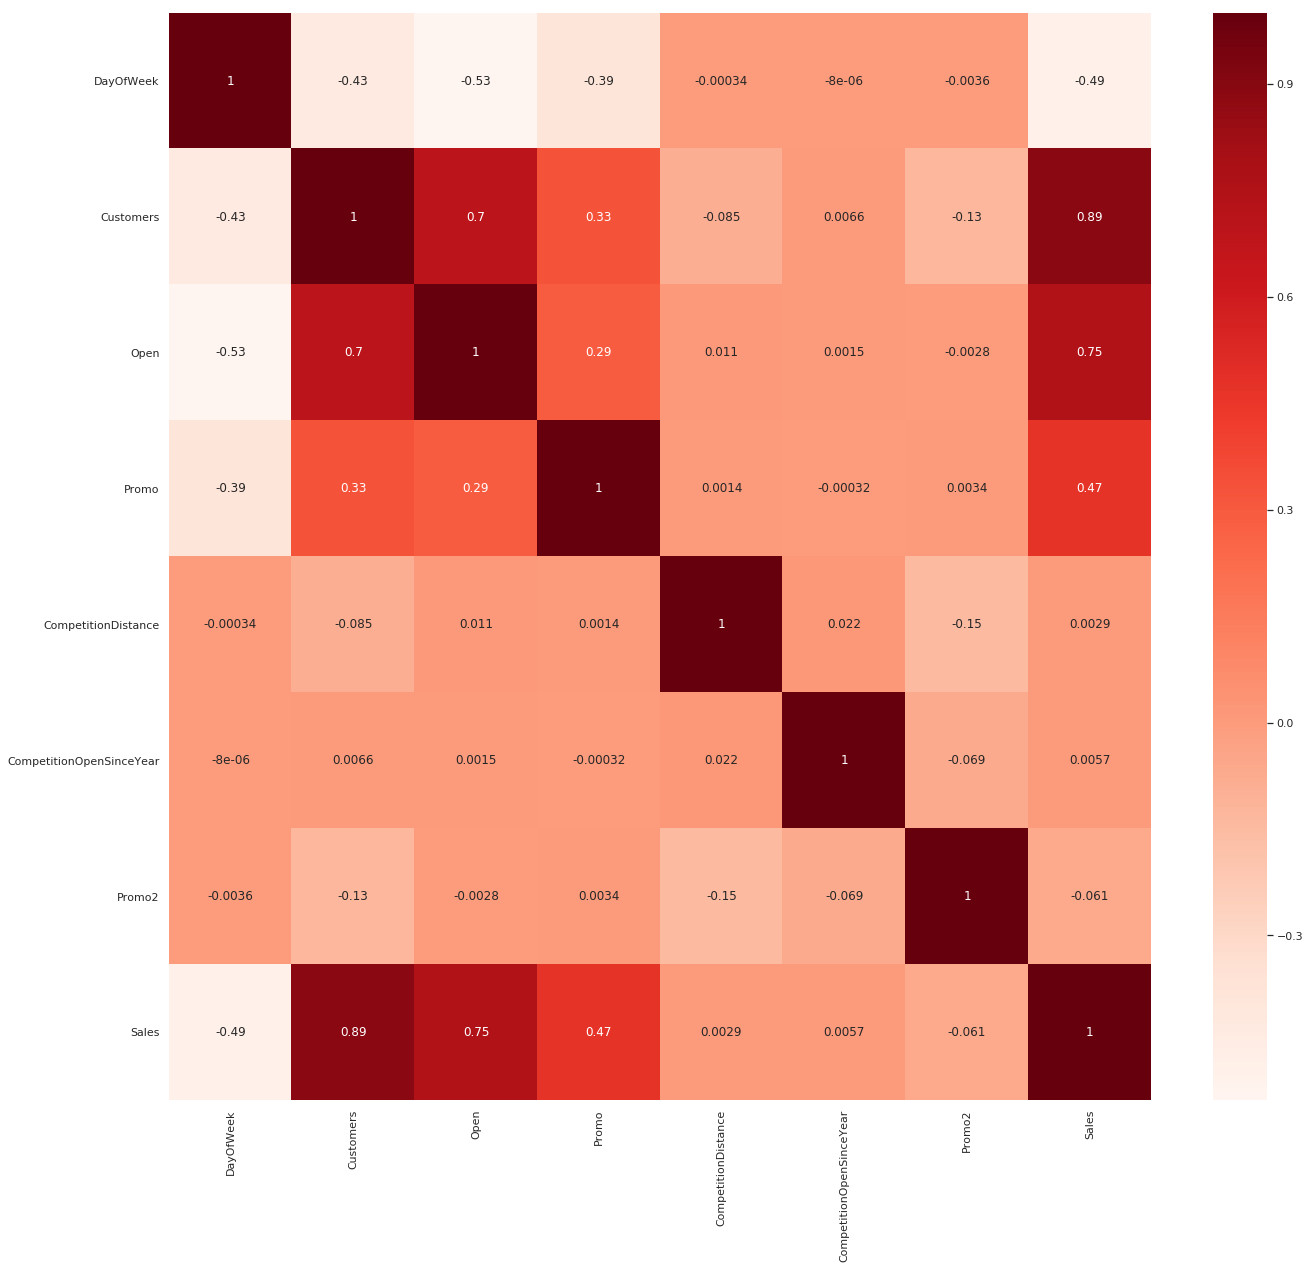

In [0]:
getCorrelations(train_set)

In [0]:
# Model Training
## Splitting train and test 
train_set=train_set.sort_index()
predictors,target,x_train,y_train,x_cv,y_cv=split_train_test(train_set)


In [0]:
algos=[RandomForestRegressor,KNeighborsRegressor,GradientBoostingRegressor,LinearRegression]
s=[]
for i in algos:
  scores(i)

/databricks/python/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
 "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/local_disk0/tmp/1603822153285-0/PythonShell.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
 import time
/databricks/python/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 y = column_or_1d(y, warn=True)

In [0]:
models = pd.DataFrame(
{
  'Method': ['RandomForestRegressor','KNeighborsRegressor','GradientBoostingRegressor','LinearRegression'],
  'Score': [s[0],s[1],s[2],s[3]]
})
models.sort_values(by='Score', ascending=False)

,Method,Score
0,RandomForestRegressor,0.879682
2,GradientBoostingRegressor,0.661434
3,LinearRegression,0.619042
1,KNeighborsRegressor,0.187730


In [0]:
model = RandomForestRegressor(oob_score = True, n_jobs = 1, random_state= 7, max_features= "auto", min_samples_leaf=4)
model.fit(x_train[predictors],y_train)

/databricks/python/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
 "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/local_disk0/tmp/1603822153285-0/PythonShell.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
 from __future__ import print_function
/databricks/python/lib/python3.7/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
 warn("Some inputs do not have OOB scores. "
Out[62]: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
 max_features='auto', max_leaf_nodes=None,
 min_impurity_decrease=0.0, min_impurity_split=None,
 min_samples_leaf=4, min_samples_split=2,
 min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
 oob_score=True, random_state=7, verbose=0, warm_start=False)

In [0]:
x_cv['pred']=model.predict(x_cv[predictors])
x_cv['actual'] = y_cv
x_cv['error%']=(abs(x_cv['actual']-x_cv['pred'])/x_cv['actual'])*100
print('Mean Absolute Error is '+ x_cv['error%'].mean().astype(str))

Mean Absolute Error is 12.171752951527253

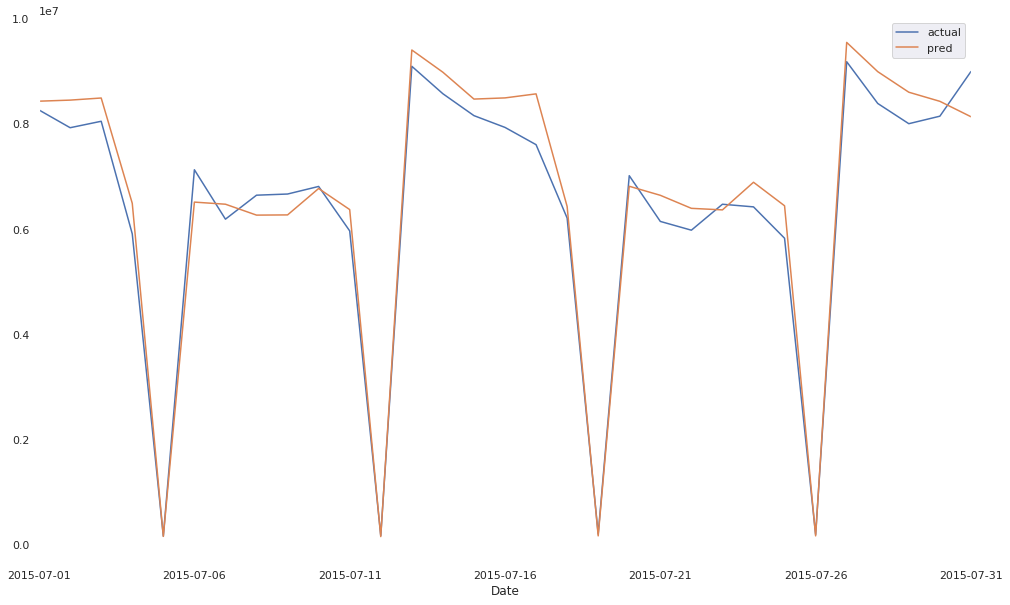

In [0]:
actualVsPred=x_cv[['Date','actual','pred']].groupby('Date').sum()
lines = actualVsPred.plot.line()

In [0]:
test_set = test.join(stores.set_index('Store'), on='Store')
fillNullsForPromo(test_set)
getDaysSincePromo(test_set)
test_set=oneHotCodeApply(train_set,test_set)
test_set.head(10)
test_set=test_set.dropna(subset=['Open'])
test_set['Sales']=model.predict(test_set[predictors]).astype(int)
#Insert your destination file path below
test_set[['Id','Store','DayOfWeek','Date','Open','Promo','StateHoliday','SchoolHoliday','Sales']].to_csv('Insert path of destination file here',index=False)
test_set.head(10)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,JanPromoInterval,FebPromoInterval,MarPromoInterval,AprPromoInterval,MayPromoInterval,JunPromoInterval,JulPromoInterval,AugPromoInterval,SepPromoInterval,OctPromoInterval,NovPromoInterval,DecPromoInterval,formatted_date,Promo2SinceDate,DaysSincePromo,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Sales
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270,9,2008,0,1,2009,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2009010,2009-01-11,2440,1,0,0,0,0,0,1,0,1,0,0,4782
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2011140,2011-04-10,1621,1,0,0,0,1,0,0,0,1,0,0,6665
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,24000,4,2013,0,1,2009,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2009010,2009-01-11,2440,1,0,0,0,1,0,0,0,0,0,1,9294
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,7520,10,2014,0,1,2009,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2009010,2009-01-11,2440,1,0,0,0,1,0,0,0,1,0,0,7812
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,2030,8,2000,0,1,2009,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2009010,2009-01-11,2440,1,0,0,0,1,0,0,0,0,0,1,8696
5,6,10,4,2015-09-17,1.0,1,0,0,a,a,3160,9,2009,0,1,2009,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2009010,2009-01-11,2440,1,0,0,0,1,0,0,0,1,0,0,6066
6,7,11,4,2015-09-17,1.0,1,0,0,a,c,960,11,2011,1,1,2012,"Jan,Apr,Jul,Oct",1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2012010,2012-01-08,1348,1,0,0,0,1,0,0,0,0,0,1,7777
7,8,12,4,2015-09-17,1.0,1,0,0,a,c,1070,7,2008,1,13,2010,"Jan,Apr,Jul,Oct",1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2010130,2010-04-04,1992,1,0,0,0,1,0,0,0,0,0,1,8856
8,9,13,4,2015-09-17,1.0,1,0,0,d,a,310,7,2008,1,45,2009,"Feb,May,Aug,Nov",0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2009450,2009-11-15,2132,1,0,0,0,0,0,0,1,1,0,0,5602
9,10,14,4,2015-09-17,1.0,1,0,0,a,a,1300,3,2014,1,40,2011,"Jan,Apr,Jul,Oct",1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2011400,2011-10-09,1439,1,0,0,0,1,0,0,0,1,0,0,6587
